## Import Packages

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
sns.set()
%matplotlib inline

## Create Data Source

In [265]:
# Import data 
data_apr_27_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt")
data_may_04_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt")
data_may_11_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt")
data_may_18_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt")
data_may_25_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt")
data_jun_06_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt")
data_jun_08_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt")
data_jun_15_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt")

# Combine data
all_data = pd.concat([data_apr_27_19, data_may_04_19, data_may_11_19, data_may_18_19, data_may_25_19
         , data_jun_06_19, data_jun_08_19, data_jun_15_19 ], ignore_index=True)

# Check that data imported successfully
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640586 entries, 0 to 1640585
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count    Dtype 
---  ------                                                                --------------    ----- 
 0   C/A                                                                   1640586 non-null  object
 1   UNIT                                                                  1640586 non-null  object
 2   SCP                                                                   1640586 non-null  object
 3   STATION                                                               1640586 non-null  object
 4   LINENAME                                                              1640586 non-null  object
 5   DIVISION                                                              1640586 non-null  object
 6   DATE                                                                  1640586 non-

## Clean and Prepare Data

In [266]:
### FILTERING, CLEANING, AND PREPARING DATA ###

# Filter data to only Regular scheduled audit events to remove any possible irregularities from recovered audits
all_data = all_data[all_data['DESC'] == 'REGULAR']

# Clean column names
all_data.columns = [column.strip() for column in all_data.columns]

# Create new variables to make datetime and turnstile easier to work with
all_data['DATETIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['TIME'])
all_data['DAYOFWEEK'] = all_data['DATETIME'].dt.day_name()
all_data['TURNSTILE'] = all_data['C/A'] + all_data['UNIT'] + all_data['SCP'] + all_data['STATION']

In [267]:
### FILTERING, CLEANING, AND PREPARING DATA ###

# Filter data to only Regular scheduled audit events to remove any possible irregularities from recovered audits
all_data = all_data[all_data['DESC'] == 'REGULAR']

# Clean column names
all_data.columns = [column.strip() for column in all_data.columns]

# Create new variables to make datetime and turnstile easier to work with
all_data['DATETIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['TIME'])
all_data['DAYOFWEEK'] = all_data['DATETIME'].dt.day_name()
all_data['WEEKDAYNUMBER'] = all_data['DATETIME'].dt.dayofweek
all_data['TURNSTILE'] = all_data['C/A'] + all_data['UNIT'] + all_data['SCP'] + all_data['STATION']

# Sort data so it is in order of turnstile and datetime
all_data.sort_values(by = ['TURNSTILE', 'DATETIME'], inplace = True)

# Check for duplicate turnstile/datetime combinations
(all_data
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)


,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-04-20 00:00:00,1
1089203,R142,R293,01-06-00,34 ST-PENN STA,2019-05-12 02:00:00,1
1089201,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 18:00:00,1
1089200,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 14:00:00,1
1089199,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 10:00:00,1
1089198,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 06:00:00,1
1089197,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 02:00:00,1
1089196,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 22:00:00,1
1089195,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 18:00:00,1
1089194,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 14:00:00,1


## Check for Irregularities in Entries Data

In [268]:
### CHECKING FOR IRREGULARITIES IN CUMULATIVE ENTRIES DATA ###

# Aggregate data to daily level
turnstiles_daily = (all_data
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

# Calculate previous data and previous entries
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])
                        ["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

# Check to see if entries from previous day are ever 
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
                        .groupby(["C/A", "UNIT", "SCP", "STATION"])
                        .size())


<ipython-input-268-196640c8757e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])


C/A   UNIT  SCP       STATION        
A025  R023  01-03-01  34 ST-HERALD SQ    55
A038  R085  00-00-01  8 ST-NYU            1
A043  R462  00-06-00  CANAL ST            1
A046  R463  00-00-03  CANAL ST            1
A049  R088  02-05-00  CORTLANDT ST       42
                                         ..
R621  R060  00-03-01  EASTN PKWY-MUSM     2
R622  R123  00-00-00  FRANKLIN AV        55
R629  R065  00-00-00  ROCKAWAY AV         1
R646  R110  01-00-01  FLATBUSH AV-B.C    55
R730  R431  00-00-04  EASTCHSTER/DYRE    51
Length: 481, dtype: int64

## Transform Entries and Exits Data

In [289]:
'''
Due to instances of previous daily turnstile entries that were higher than the current daily entries 
(see cell above), there was evidence that some counters were going backwards. 
Therefore, we used absolute value in net calculations
'''


# Resort data to ensure it is in correct order
all_data.sort_values(by = ['TURNSTILE', 'DATETIME'], inplace = True)

# Net entries and net exit calculations using absolute value
all_data['NET_ENTRIES'] = all_data.groupby('TURNSTILE')['ENTRIES'].diff().abs()
all_data['NET_EXITS'] = all_data.groupby('TURNSTILE')['EXITS'].diff().abs()

# Removing rows with entries or exits above 10,000 since anything over 10,000 entries or exits means that 
# at least 2,500 people went through that turnstile every hour for four hours straight and that seems unrealistic
indexNames = all_data[(all_data['NET_ENTRIES'] > 10000 ) | (all_data['NET_EXITS'] > 10000)].index
all_data_clean = all_data.drop(indexNames)

# Combine net entries and net exits into variable for all foot traffic
all_data_clean['TOTAL_FOOT_TRAFFIC'] = all_data_clean['NET_ENTRIES'] + all_data_clean['NET_EXITS']

# Verify data looks correct
test_df = all_data_clean.groupby('STATION')['TOTAL_FOOT_TRAFFIC'].mean().reset_index()
test_df.sort_values('TOTAL_FOOT_TRAFFIC',ascending=False)

STATION  TOTAL_FOOT_TRAFFIC
376         YORK ST              940.26
14   14 ST-UNION SQ              717.16
286       MYRTLE AV              716.93
84       57 ST-7 AV              694.22
56            30 AV              678.53
..              ...                 ...
147     BEACH 98 ST               30.29
161   BROAD CHANNEL               18.77
140    BEACH 105 ST               16.54
353   TOMPKINSVILLE               15.99
308   ORCHARD BEACH                1.17

[378 rows x 2 columns]

## Data Visualization

In [270]:
# Daily Station Data
stations_daily = (all_data_clean.groupby(['STATION','DATE','DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].sum()
                 .reset_index())
stations_daily.head()

STATION        DATE  DAYOFWEEK  TOTAL_FOOT_TRAFFIC
0    1 AV  04/20/2019   Saturday           22,404.00
1    1 AV  04/21/2019     Sunday           24,402.00
2    1 AV  04/22/2019     Monday           35,706.00
3    1 AV  04/23/2019    Tuesday           36,389.00
4    1 AV  04/24/2019  Wednesday           37,278.00

In [271]:
#Read additional datasest for female/male ratio-Subway Station and median house sales price to zip code.

female_male_ratio_by_zip = pd.read_csv("female_male_ratio_subway_mapping.csv")
female_male_ratio_by_zip.rename(columns = {'Stop Name':'STATION'},inplace=True)
female_male_ratio_by_zip['STATION'] = female_male_ratio_by_zip['STATION'].str.upper()
female_male_ratio_by_zip.drop_duplicates(['STATION','zipcode'],inplace = True)

zip_code_med_sales = pd.read_csv('zip_code_to_median_sales.txt')
zip_code_med_sales.rename(columns = {'ZIP CODE':'zipcode'},inplace=True)

In [283]:
#Merge new female/male ratio data using Station name as the key.

all_data_fm = pd.merge(all_data_clean,female_male_ratio_by_zip,how='left',on='STATION')

#Merge median house sale price using zip code as key
all_data_fmr_mhs = pd.merge(all_data_fm,zip_code_med_sales,how='left',on='zipcode')

#all_data_fmr_mhs.dropna(inplace=True)
#With multiple zip codes for one station, only keep the first duplicate
all_data_fmr_mhs.drop_duplicates(['DATETIME','TURNSTILE'],inplace=True) 

In [290]:
#Create a table with median sales price for each station
pd.options.display.float_format = '{:,.2f}'.format
station_data = all_data_fmr_mhs.groupby('STATION')[['TOTAL_FOOT_TRAFFIC','female_male_ratio','SALE PRICE']].mean().reset_index()
final_data_table = station_data.rename(columns={'STATION':"Station",'TOTAL_FOOT_TRAFFIC':'Average Daily Traffic','female_male_ratio':'Female/Male Ratio','SALE PRICE':'Median House Prices'},inplace=False,errors='ignore')

#Show '-' where data is not available for the table
#final_data_table = final_data_table.replace(np.nan,'-')
#or drop all lines with the missing values
final_data_table.dropna(inplace=True)

final_data_table.sort_values('Average Daily Traffic',ascending=False,inplace=True)
final_data_table.reset_index()
final_data_table.head(10) #York St should not be showing the highest daily foot traffic

,Station,Average Daily Traffic,Female/Male Ratio,Median House Prices
376,YORK ST,940.26,0.98,"899,450.00"
14,14 ST-UNION SQ,717.16,1.06,"1,225,000.00"
286,MYRTLE AV,716.93,1.02,"433,890.00"
84,57 ST-7 AV,694.22,0.98,"1,007,500.00"
362,W 4 ST-WASH SQ,650.34,0.98,"1,007,500.00"
59,34 ST-HERALD SQ,643.23,0.98,"1,007,500.00"
302,NEWKIRK PLAZA,631.29,1.24,"507,500.00"
229,GRAND ST,597.46,1.02,"845,000.00"
306,NOSTRAND AV,591.09,1.27,"472,500.00"
67,42 ST-BRYANT PK,587.05,0.98,"1,007,500.00"


In [161]:
#Create a table for the top Female to Male ratios 
station_fm_ratio_table = (female_male_ratio_by_zip
                          .sort_values('female_male_ratio',ascending=False)[['STATION','female_male_ratio']]
                          .dropna()
                          .drop_duplicates('STATION')
                          .reset_index())
del station_fm_ratio_table['index']
station_fm_ratio_table.rename(columns={'STATION':'Station','female_male_ratio':'Female/Male Ratio'},inplace=True)
station_fm_ratio_table.head(25)

,Station,Female/Male Ratio
0,116 ST,1.42
1,77 ST,1.42
2,59 ST,1.42
3,51 ST,1.42
4,145 ST,1.42
5,135 ST,1.42
6,GRAND CENTRAL-42 ST,1.42
7,96 ST,1.42
8,SUTTER AV-RUTLAND RD,1.31
9,ROCKAWAY AV,1.30


In [ ]:
#Create a table including the Female/Male ratio for Stations with the highest daily subway traffic



In [121]:
# Graph code for average foot traffic for top 10 station 

top10_stations = \
    (stations_daily.groupby(['STATION'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by='TOTAL_FOOT_TRAFFIC',ascending=False)
                   .head(10))

#plt.bar(top10_stations['STATION'], top10_stations['TOTAL_FOOT_TRAFFIC'], align='center', alpha=0.5)
#plt.xticks(top10_stations['STATION'], rotation=45, ha='right')
#plt.ylabel('AVG DAILY VOLUME')
#plt.xlabel('TOP 10 STATIONS')
#plt.title('HIGHEST TRAFFIC SUBWAY STATIONS')
#plt.show()

In [9]:
# Creating top 10 stations data subset of original data

top10_stations_daily = stations_daily[stations_daily['STATION'].isin(top10_stations['STATION'])]
top10_stations_daily.head()

,STATION,DATE,DAYOFWEEK,WEEKDAYNUMBER,TOTAL_FOOT_TRAFFIC
504,125 ST,04/20/2019,Saturday,5,77333.0
505,125 ST,04/21/2019,Sunday,6,85126.0
506,125 ST,04/22/2019,Monday,0,122196.0
507,125 ST,04/23/2019,Tuesday,1,132198.0
508,125 ST,04/24/2019,Wednesday,2,135199.0


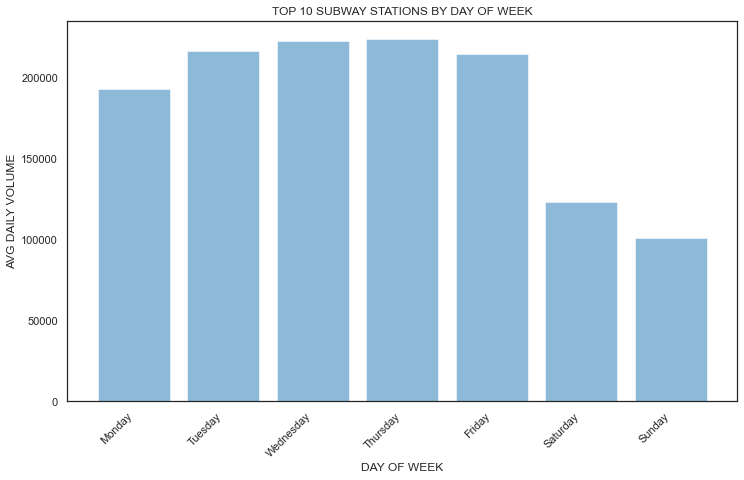

In [20]:
# Graph code for average foot traffic by day of week for top 10 stations only

dayofweek_station_avg = \
    (top10_stations_daily.groupby(['DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by ='WEEKDAYNUMBER')
                   )

sns.set_style("white")
plt.figure(figsize=(12, 7))
plt.bar(dayofweek_station_avg['DAYOFWEEK'], dayofweek_station_avg['TOTAL_FOOT_TRAFFIC'], align='center', alpha=0.5)
plt.xticks(dayofweek_station_avg['DAYOFWEEK'], rotation=45, ha='right')
plt.ylabel('AVG DAILY VOLUME')
plt.xlabel('DAY OF WEEK')
plt.title('TOP 10 SUBWAY STATIONS BY DAY OF WEEK')
plt.show()

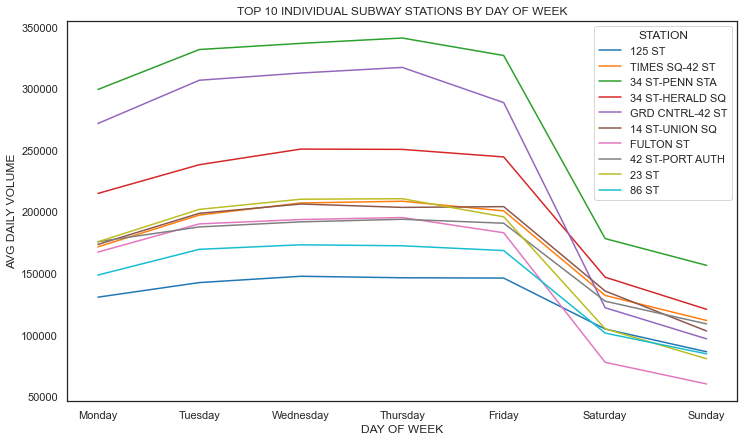

In [19]:
# Top 10 stations grouped by weekday and graphed

top10_stations_weekday_avg = \
    (top10_stations_daily.groupby(['STATION', 'DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by ='WEEKDAYNUMBER')
                   )


sns.set_palette('tab10',10)
sns.set_style("white")
plt.figure(figsize=(12, 7))
plt.xlabel('DAY OF WEEK')
plt.ylabel('AVG DAILY VOLUME')
plt.title('TOP 10 INDIVIDUAL SUBWAY STATIONS BY DAY OF WEEK')
sns.lineplot(x="DAYOFWEEK", y="TOTAL_FOOT_TRAFFIC", hue="STATION", data = top10_stations_weekday_avg);

## Other Code 
##### Just in case we need it, I can delete it if we don't

In [13]:
# Wonjae's code by four hour period
four_hr = (all_data_clean.groupby(['DATETIME','TURNSTILE'])['TOTAL_FOOT_TRAFFIC'].sum()
              .reset_index()
              .sort_values(by='TOTAL_FOOT_TRAFFIC'
                           ,ascending=False))
four_hr.head(25)

,DATETIME,TURNSTILE,TOTAL_FOOT_TRAFFIC
950712,2019-05-22 11:52:24,PTH03R55200-02-01JOURNAL SQUARE,17229.0
750703,2019-05-15 16:00:00,N503R02100-00-0442 ST-BRYANT PK,17193.0
413524,2019-05-04 01:00:00,R523R14700-00-0561 ST WOODSIDE,13808.0
1540325,2019-06-11 18:56:53,PTH13R54100-00-07THIRTY ST,13778.0
205766,2019-04-27 01:00:00,H039R37500-00-00NEW LOTS,13640.0
577259,2019-05-09 17:00:00,JFK03R53600-00-05JFK JAMAICA CT1,13388.0
1001676,2019-05-24 07:01:30,PTH03R55200-00-09JOURNAL SQUARE,13373.0
409676,2019-05-04 00:00:00,H023R23600-00-02DEKALB AV,13149.0
207265,2019-04-27 01:00:00,R730R43100-00-02EASTCHSTER/DYRE,12732.0
1001560,2019-05-24 06:56:09,PTH07R55000-00-06CITY / BUS,12527.0


In [15]:
## Other code
"""
top10_stations = \
    (stations_daily.groupby(['STATION'])['TOTAL_FOOT_TRAFFIC'].sum()
                   .reset_index()
                   .sort_values(by='TOTAL_FOOT_TRAFFIC',ascending=False)
                   .STATION.head(10))
top10_stations

stations_daily_top10 = \
    stations_daily[stations_daily[‘STATION’].isin(top10_stations)]


# use seaborn to create a boxplot by station
sns.boxplot(‘total_foot_traffic’, ‘STATION’, data=stations_daily_top10)

df_weekday = (stations_daily.groupby([‘day_of_week’])[‘total_foot_traffic’].sum()
              .reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))
(stations_daily.query(‘STATION == “34 ST-PENN STA”’).reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))

sns.distplot(turnstiles_daily[‘ENTRIES’]
             [turnstiles_daily[‘ENTRIES’] < 50000])

(stations_daily.query(‘STATION == “GRD CNTRL-42 ST”’).reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))
"""

"\ntop10_stations =     (stations_daily.groupby(['STATION'])['TOTAL_FOOT_TRAFFIC'].sum()\n                   .reset_index()\n                   .sort_values(by='TOTAL_FOOT_TRAFFIC',ascending=False)\n                   .STATION.head(10))\ntop10_stations\n\nstations_daily_top10 =     stations_daily[stations_daily[‘STATION’].isin(top10_stations)]\n\n\n# use seaborn to create a boxplot by station\nsns.boxplot(‘total_foot_traffic’, ‘STATION’, data=stations_daily_top10)\n\ndf_weekday = (stations_daily.groupby([‘day_of_week’])[‘total_foot_traffic’].sum()\n              .reset_index()\n              .sort_values(by=‘total_foot_traffic’\n                           ,ascending=False))\n(stations_daily.query(‘STATION == “34 ST-PENN STA”’).reset_index()\n              .sort_values(by=‘total_foot_traffic’\n                           ,ascending=False))\n\nsns.distplot(turnstiles_daily[‘ENTRIES’]\n             [turnstiles_daily[‘ENTRIES’] < 50000])\n\n(stations_daily.query(‘STATION == “GRD CNTRL-42 ST

In [16]:
#dayofweek_avg.head(20)
mask = stations_daily['STATION'].isin(top10_stations)

In [17]:
mask.value_counts()

False    21098
Name: STATION, dtype: int64